In [5]:
import sys
import os
import netsquid as ns
import pydynaa
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

from numpy import random
from itertools import combinations

from netsquid.nodes import Node, Connection, Network

from netsquid.protocols import Protocol, NodeProtocol, Signals

from netsquid.util.datacollector import DataCollector

import netsquid.qubits.ketstates as ks

from netsquid.examples.teleportation import example_network_setup
from netsquid.qubits import qubitapi as qapi
from netsquid.qubits.qubitapi import ops
from netsquid.qubits import StateSampler

from netsquid.components import ClassicalChannel, QuantumChannel, QuantumProgram, QuantumProcessor, INSTR_MEASURE
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.models import DelayModel, FixedDelayModel, FibreDelayModel, FibreLossModel, DephaseNoiseModel, DepolarNoiseModel
from netsquid.components.qprocessor import QuantumProcessor, PhysicalInstruction
from netsquid.components.instructions import INSTR_ROT_Z, INSTR_INIT, INSTR_EMIT, IMeasureFaulty

import netsquid.components.instructions as instr

import import_ipynb
from NoiseModels import EmissionNoiseModel, CollectiveDephasingNoiseModel
from Instructions import IonTrapMultiQubitRotation, IonTrapMSGate, INSTR_INIT_BELL
from nstrappedions.InitPhoton import SendPhoton
from programs import emit_prog

In [6]:
"""Validate that emission success probability from an ion trap is as expected."""


def setup(collection_efficiency, fiber_length, attenuation):

    ion_trap = SendPhoton(num_positions=1, collection_efficiency=collection_efficiency)
    #ion_trap = SendPhoton(num_positions=2)
    
    ion_trap.add_instruction(instruction=INSTR_INIT_BELL, duration=0)
    q1, q2 = qapi.create_qubits(2)
    ns.qubits.operate(q1, ops.H)
    ns.qubits.operate([q1, q2], ops.CNOT)
    
    
    loss_model = FibreLossModel(p_loss_length=attenuation, p_loss_init=0)
    fiber = QuantumChannel(name="fiber", length=fiber_length,
                           models={"quantum_loss_model": loss_model},
                           transmit_empty_items=True)
    fiber.ports["send"].connect(ion_trap.ports["qout"])
    collection_port = fiber.ports["recv"]

    # collection_port = ion_trap.ports["qout"]

    return ion_trap, collection_port

In [7]:

# ns.logger.setLevel(logging.DEBUG)

# x = np.arange(0.1, 1, 0.1)
# xstring = "collection efficiency"

x = range(1, 10)
xstring = "fiber length"

collection_efficiency = 1
fiber_length = 1
attenuation = 0.25

success_probs = []
success_prob_errors = []
expected_success_probs = []

for fiber_length in x:

    ion_trap, collection_port = setup(collection_efficiency=collection_efficiency,
                                      fiber_length=fiber_length,
                                      attenuation=attenuation)
    #fail_count = 0
    num_tries = 500
    outcomes = []
    for _ in range(num_tries):
        ion_trap.execute_program(emit_prog)
        ns.sim_run()
        emitted_message = collection_port.rx_output()
        emitted_qubit = emitted_message.items[0]
        if emitted_qubit is None:
            outcomes.append(0)
        else:
            if emitted_qubit.qstate is None:
                outcomes.append(0)
            else:
                outcomes.append(1)

    success_prob = np.mean(outcomes)
    success_probs.append(success_prob)
    success_prob_error = np.std(outcomes) / math.sqrt(len(outcomes))
    success_prob_errors.append(success_prob_error)
    expected_success_prob = collection_efficiency * np.power(10, - attenuation * fiber_length / 10)
    expected_success_probs.append(expected_success_prob)

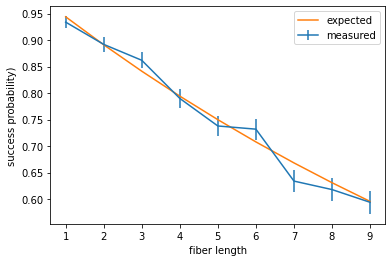

In [8]:
plt.figure()
plt.errorbar(x, y=success_probs, yerr=success_prob_errors, label="measured")
plt.plot(x, expected_success_probs, label="expected")
plt.xlabel(xstring)
plt.ylabel("success probability)")
plt.legend()
plt.show()